# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [2]:
# Import the tables of the data set as dataframes.
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)
# Default silhouette_score does not support multivariate
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [3]:
# Import the tables of the data set as dataframes.

DATA_DIR_full_dataset = './data/00_data_full/' # You many change the directory
DATA_DIR_small_dataset = './data/00_data_1000_students/'

# You can use the nrows=X argument in pd.read_csv to truncate your data
#users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR_small_dataset), index_col=0)
#events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR_small_dataset), index_col=0)
#subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR_small_dataset), index_col=0)
users = pd.read_csv('{}/full_calcularis_users.csv'.format(DATA_DIR_full_dataset), index_col=0)
events = pd.read_csv('{}/full_calcularis_events.csv'.format(DATA_DIR_full_dataset), index_col=0)
subtasks = pd.read_csv('{}/full_calcularis_subtasks.csv'.format(DATA_DIR_full_dataset), index_col=0)

print(f'Number of users: {len(users)}')
print(f'Number of events: {len(events)}')
print(f'Number of subtasks: {len(subtasks)}')

Number of users: 64932
Number of events: 2185200
Number of subtasks: 3502884


## Task 0: Research Question

**Research question:**
*Time series clustering per student to look at the difference between guided training and free training, with the goal of learning what type of learner each  student is.*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

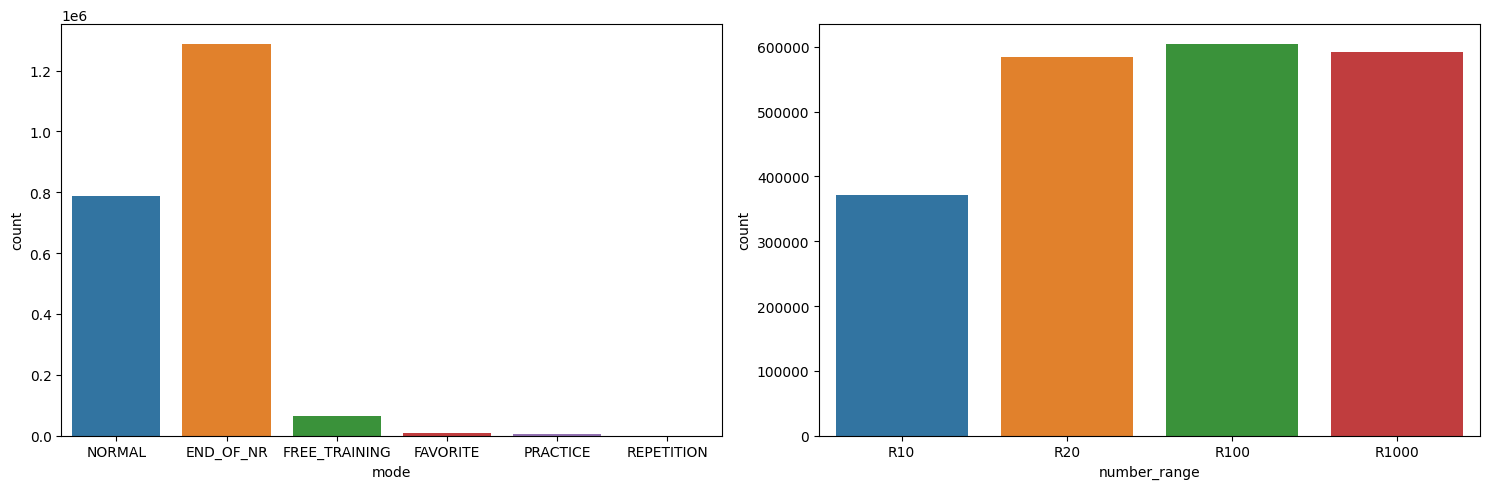

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(data = pd.DataFrame(events['mode']), x = 'mode', ax = axs[0])
sns.countplot(data = pd.DataFrame(events['number_range']), x = 'number_range', ax = axs[1])
plt.tight_layout()
plt.show()

In [5]:
# Sort the dataframes per training mode: guided training (gt) and free training (ft)

events_gt = events[events['mode'].isin(['NORMAL', 'END_OF_NR', 'FAVORITE', 'REPETITION'])]
events_ft = events[events['mode'].isin(['FREE_TRAINING'])]
subtasks_gt = subtasks[subtasks['event_id'].isin(events_gt.index)]
subtasks_ft = subtasks[subtasks['event_id'].isin(events_ft.index)]
print(f'Length of GUIDED training events dataframe: {len(events_gt)}\n Length of GUIDED training subtasks dataframe: {len(subtasks_gt)}')
print(f'Length of FREE training events dataframe: {len(events_ft)}\n Length of FREE training subtasks dataframe: {len(subtasks_ft)}')

Length of GUIDED training events dataframe: 2085189
 Length of GUIDED training subtasks dataframe: 3358682
Length of FREE training events dataframe: 63447
 Length of FREE training subtasks dataframe: 133400


In [10]:
print(f"In guided we have {len(events_gt['user_id'].unique())} users and free training {len(events_ft['user_id'].unique())}")

In guided we have 59817 users and free training 8137


In [11]:
WEEKS_A_YEAR = 52 
WEEKS = 15

def create_events_subtasks(mode):
    if (mode == 'guided'):
        df_events = events_gt
        df_subtasks = subtasks_gt
    elif (mode == 'free'):
        df_events = events_ft
        df_subtasks = subtasks_ft
    else:
        raise ValueError("Incorrect mode selected: either guided or free")
    return df_events, df_subtasks

def create_smaller_dataset(events, subtasks, nb_of_considered_users):
    #random sample on users
    different_users = np.array(events['user_id'].unique())
    users_rng = np.random.choice(different_users, nb_of_considered_users)
    events_small = events.loc[events['user_id'].isin(users_rng)]
    subtasks_small = subtasks.loc[subtasks['user_id'].isin(users_rng)]
    return events_small, subtasks_small

def add_week_dimension(df_events, df_subtasks):
    events_copy = df_events.copy()
    subtasks_copy = df_subtasks.copy()
    
    years = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year
    first_year = years.min()
    events_copy["week"] = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
    events_copy["week"] = events_copy["week"]*WEEKS_A_YEAR +pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().week
    start_weeks = pd.Series(events_copy.groupby(by="user_id").min()["week"], name="start_weeks")
    subtasks_copy["week"] = pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
    subtasks_copy["week"] = subtasks_copy["week"]*WEEKS_A_YEAR+pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
    # Now actually change it to each user starting with week 0
    for user, start in start_weeks.items():
        events_copy.loc[events_copy["user_id"] == user, "week"] = events_copy[events_copy["user_id"] == user]["week"]-start
        subtasks_copy.loc[subtasks_copy["user_id"] == user, "week"] = subtasks_copy[subtasks_copy["user_id"] == user]["week"]-start
    return events_copy, subtasks_copy

In [12]:
# Effort features
def effort_features(df_events, df_subtasks):
  # Total time learning per week
  time_online = df_events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]
  #print(time_online.head())
  # TODO maybe total time online per week?

  # Total interactions per week, here interactions we define as events and weeks
  events_done = pd.Series(df_events.groupby(by=["user_id", "week"]).count()["skill_id"], name="events_done")
  #sns.histplot(events_done)
  #plt.show()

  subtasks_done = pd.Series(df_subtasks.groupby(by=["user_id", "week"]).count()["event_id"], name="subtasks_done")
  #sns.histplot(subtasks_done)
  #plt.show()
  
  # features Maxime
  df_events['difficulty'] = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
  features = pd.DataFrame()
  features['Nb_of_different games'] = df_events.groupby(['user_id', 'week'])['game_name'].unique().apply(lambda example : len(example))
  features['correct'] = df_subtasks.groupby(['user_id','week'])['correct'].apply(lambda example: sum(example)/len(example))
  features['avg_difficulty'] = df_events.groupby(['user_id','week'])['difficulty'].mean()

  effort = pd.DataFrame({
    "time_online": time_online,  
    "events_done": events_done,  
    "subtasks_done": subtasks_done,
    "Nb_of_different games": features['Nb_of_different games'],  
    "correct": features['correct'],
    #  "avg_difficulty": features['avg_difficulty']   # Vivi's feature contains this
    })
  return effort

In [13]:
# Assessment feature
def assessment_features(df_events, df_subtasks):
    # Parse ranges in two different ways. TODO: choose which one makes more sense
    df_events['range_linear']  = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
    df_events['range_default'] = df_events['number_range'].replace({'R10': 10, 'R20': 20, 'R100': 100, 'R1000': 1000})

    # assessment['num_attempts'] = subtasks.groupby(['user_id','week'])['event_id'].count()
    # assessment = assessment.merge(events['user_id', 'week', 'range_linear', 'range_default'], on= ['user_id', 'week'], how='left')

    # Number of attempts per user and week on every event
    subtasks_count = df_subtasks.groupby(['user_id','week', 'event_id']).size().reset_index().rename(columns={0: 'user_num_attempts'})
    user_assessment = df_events.merge(subtasks_count, on=['user_id','week', 'event_id'])[['event_id','user_id', 'week', 'range_linear', 'range_default', 'user_num_attempts']]

    # Number of unique users per subtask
    # TODO: check whether num_users_per_subtask is correct bc weird results with small dataset
    # Checking by 
    # user_assessment.groupby('user_id')['event_id'].count().rename('events_count').reset_index()
    # subtasks[subtasks['event_id'] == 0]
    num_users_per_subtask = df_subtasks.groupby('event_id')['user_id'].nunique()
    num_users_per_subtask.reset_index()
    # Events played by user
    # events_per_user = user_assessment.groupby('user_id')['event_id'].count().rename('idk_count').reset_index()

    # Can we know users played by users? find unique event_id by user_id in subtasks?
    # subtasks.groupby(['event_id', 'user_id']).count().reset_index().merge(subtasks, on= ['event_id', 'user_id'], how= 'left')

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Left join between users_assessment and average_assessment
    user_assessment = user_assessment.merge(avg_assessment_lin, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_lin'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_lin']

    user_assessment = user_assessment.merge(avg_assessment_def, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_def'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_def']
    range_linear = user_assessment.groupby(['user_id', 'week']).count()['range_linear']
    # range_linear.tail(20)

    # Assessment pipeline for linear and default difficulty range

    user_num_attempts = user_assessment.groupby(['user_id', 'week'])['user_num_attempts'].mean()
    num_users_tried = user_assessment.groupby(['user_id', 'week'])['num_users_tried'].mean()

    range_linear = user_assessment.groupby(['user_id', 'week'])['range_linear'].mean()
    attempts_diff_lin = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_lin = user_assessment.groupby(['user_id', 'week'])['min_range_lin'].mean()
    avg_range_lin = user_assessment.groupby(['user_id', 'week'])['avg_range_lin'].mean()
    max_range_lin = user_assessment.groupby(['user_id', 'week'])['max_range_lin'].mean()

    assessment_lin = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_lin,
        "min_range_lin": min_range_lin,
        "avg_range_lin": avg_range_lin,
        "max_range_lin": max_range_lin,
    })

    range_default = user_assessment.groupby(['user_id', 'week'])['range_default'].mean()
    attempts_diff_def = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_def = user_assessment.groupby(['user_id', 'week'])['min_range_def'].mean()
    avg_range_def = user_assessment.groupby(['user_id', 'week'])['avg_range_def'].mean()
    max_range_def = user_assessment.groupby(['user_id', 'week'])['max_range_def'].mean()

    assessment_def = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_def,
        "min_range_def": min_range_def,
        "avg_range_def": avg_range_def,
        "max_range_def": max_range_def,
    })

    return assessment_lin, assessment_def

In [14]:
# Preprocessing pipeline
training_mode = 'guided'
df_events, df_subtasks = create_events_subtasks(training_mode)
df_events, df_subtasks = create_smaller_dataset(df_events, df_subtasks, nb_of_considered_users = 59800) #there might not be enough users for free training if number too big
df_events, df_subtasks = add_week_dimension(df_events, df_subtasks)

In [13]:
effort = effort_features(df_events, df_subtasks)
effort.head(1)

/tmp/ipykernel_12830/2928831407.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_online = df_events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]


,,time_online,events_done,subtasks_done,Nb_of_different games,correct
user_id,week,,,,,
3,0,89136.0,5,8.0,5,0.625


In [14]:
assessment_lin, assessment_def = assessment_features(df_events, df_subtasks)
assessment_lin.head(1)

,,range_linear,user_num_attempts,num_users_tried,attempts_diff,min_range_lin,avg_range_lin,max_range_lin
user_id,week,,,,,,,
3,0,1.4,1.6,1.0,0.2,1.4,1.4,1.4


In [15]:
def correct_number_users(df_events, effort):
    effort_def = effort.copy()
    arr1 = np.array(df_events['user_id'].unique())
    arr2 = np.array(effort_def.index.get_level_values('user_id').unique())
    effort_def = effort_def.dropna(thresh = 3)
    mask = np.in1d(arr2, arr1)
    list_users_id_to_remove = arr2[~mask]
    return effort_def

effort = correct_number_users(df_events, effort)
print(f"Count of users in effort after correction: {len(effort.index.get_level_values('user_id').unique())}")

Count of users in effort after correction: 37921


In [16]:
#fix problem with number of users
print(f"Count of users in events dataframe: {len(df_events['user_id'].unique())}")
print(f"Count of users in effort: {len(effort.index.get_level_values('user_id').unique())}")

arr1 = np.array(df_events['user_id'].unique())
arr2 = np.array(effort.index.get_level_values('user_id').unique())

mask = np.in1d(arr2, arr1)
uniqueNums = arr2[~mask]
print(f'Count of users to remove: {len(uniqueNums)}')
users_to_remove = effort.loc[uniqueNums]

Count of users in events dataframe: 37921
Count of users in effort: 37921
Count of users to remove: 0


## Task 2: Model Building

Train a model for your research question. 

In [17]:
# Your code for training a model goes here

# Combine all features and for now use the complete first 15 weeks (later also with 15 active weeks)
combined_features = effort[effort.index.get_level_values(1) <= WEEKS]
combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']

combined_features.head()

/tmp/ipykernel_12830/3977808626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']


time_online  events_done  subtasks_done  Nb_of_different games  \
user_id week                                                                   
3       0         89136.0            5            8.0                      5   
        1         54265.0            5            6.0                      3   
        2         15163.0            2            2.0                      1   
        3         49803.0            5            5.0                      3   
        4         65637.0            4            6.0                      4   

              correct  attempts_diff  
user_id week                          
3       0       0.625            0.2  
        1       0.500           -1.0  
        2       0.500           -2.0  
        3       0.400           -2.0  
        4       1.000           -1.5

Simpler direct application of tslearn k-means to the raw set of our features.

In [18]:
reshaped_feature = pd.DataFrame(combined_features, copy=True).fillna(0)
print(f"Each element will be a list of {reshaped_feature.columns.values} features")
# Create a combined feater list and unstack it
reshaped_feature["combined"] = reshaped_feature.values.tolist()
reshaped_feature = reshaped_feature["combined"].unstack(level=1)
# Sort columns by week, as now it is a time series
reshaped_feature = reshaped_feature.reindex(sorted(reshaped_feature.columns), axis=1)
reshaped_feature.head(2)

Each element will be a list of ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different games'
 'correct' 'attempts_diff'] features


week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,,,
3,"[89136.0, 5.0, 8.0, 5.0, 0.625, 0.2]","[54265.0, 5.0, 6.0, 3.0, 0.5, -1.0]","[15163.0, 2.0, 2.0, 1.0, 0.5, -2.0]","[49803.0, 5.0, 5.0, 3.0, 0.4, -2.0]","[65637.0, 4.0, 6.0, 4.0, 1.0, -1.5]","[30315.0, 3.0, 3.0, 2.0, 0.6666666666666666, -...","[2994.0, 1.0, 2.0, 1.0, 1.0, -2.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3698.0, 1.0, 2.0, 1.0, 1.0, -2.0]"
5,"[20900.0, 3.0, 5.0, 2.0, 0.4, 0.6666666666666666]","[58583.0, 6.0, 6.0, 4.0, 0.8333333333333334, -...","[8200.0, 1.0, 1.0, 1.0, 1.0, -1.0]","[30657.0, 3.0, 3.0, 2.0, 1.0, -2.0]",NaN,"[6113.0, 1.0, 1.0, 1.0, 0.0, -2.0]",NaN,NaN,NaN,NaN,"[6130.0, 1.0, 1.0, 1.0, 1.0, -2.0]",NaN,NaN,NaN,"[6018.0, 1.0, 1.0, 1.0, 0.0, -2.0]","[12096.0, 2.0, 3.0, 2.0, 0.6666666666666666, -..."


In [19]:
# Fill missing values with NaN filler list --> impossible to do in a smarter way
nan_filler_list = np.array([0] * len(combined_features.columns))
arr = reshaped_feature.values
nan_mask = np.vectorize(lambda x: isinstance(x, float) and np.isnan(x))(arr)
for i in range(len(arr)):
    for j in range(len(arr[i])):
        if nan_mask[i][j]:
            arr[i][j] = nan_filler_list
        else:
            arr[i][j] = np.array(arr[i][j])
            
arr = np.array([np.stack(x) for x in arr])

DBA k-means for multivariate clustering
Doing now with 2 clusters.
Doing now with 3 clusters.
Doing now with 4 clusters.
Doing now with 5 clusters.
Doing now with 6 clusters.
Doing now with 7 clusters.
Doing now with 8 clusters.
Doing now with 9 clusters.


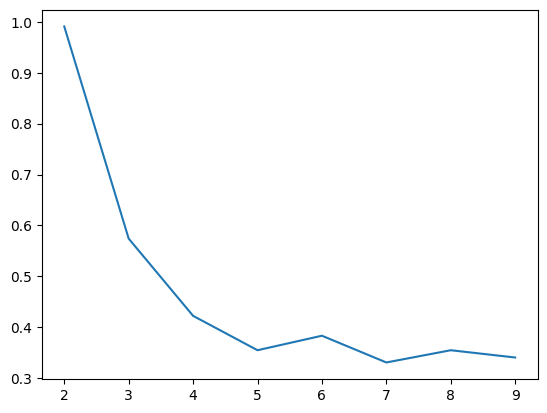

In [20]:
# Multivariate time series clustering using normal DTW
print("DBA k-means for multivariate clustering")
silhouette_list = []
rang = range(2, 10)
for clusters in rang:
    print(f"Doing now with {clusters} clusters.")
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                          #n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=50,
                          random_state=69)
    y_pred = dba_km.fit_predict(arr)
    ss = silhouette_score(arr, y_pred)
    silhouette_list.append(ss)

sns.lineplot(x=rang, y=silhouette_list)
plt.show()

softdtw k-means for multivariate clustering
Doing now with 2 clusters.
Doing now with 3 clusters.
Doing now with 4 clusters.
Doing now with 5 clusters.
Doing now with 6 clusters.
Doing now with 7 clusters.
Doing now with 8 clusters.
Doing now with 9 clusters.
Doing now with 10 clusters.


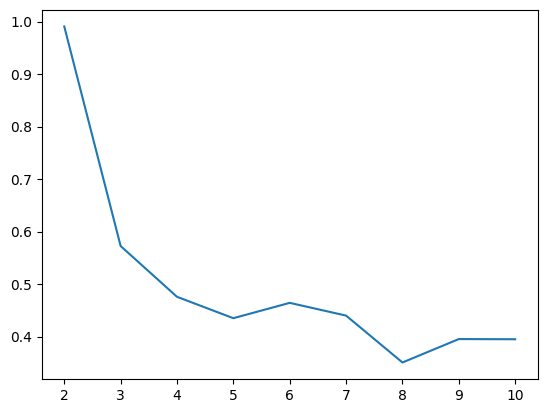

In [31]:
# Multivariate time series clustering using soft DTW
print("softdtw k-means for multivariate clustering")
silhouette_list = []
rang = range(2, 11)
for clusters in rang:
    print(f"Doing now with {clusters} clusters.")
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                          #n_init=2,
                          metric="softdtw",
                          metric_params={"gamma": .5},
                          verbose=False,
                          max_iter_barycenter=50,
                          random_state=69)
    y_pred = dba_km.fit_predict(arr)
    ss = silhouette_score(arr, y_pred)
    silhouette_list.append(ss)

sns.lineplot(x=rang, y=silhouette_list)
plt.show()

Clusters of size 2 and 3 are both not really interpretable, because both have students with too big variance in them. 6 clusters seems to be a decent Silhouette score for which we have good seperation of the clusters, which can also be interpreted.